In [1]:
from dataloader import DataLoader

loader = DataLoader(hs_code=282520)

_initialize_data took 33.7638 seconds


In [2]:
df = loader.get_data()

In [19]:
import os
import math
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import to_undirected
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
import networkx_temporal as nxt
import leidenalg as la
import igraph as ig
import matplotlib.colors as mcolors
from itertools import product

############################################################
# Parameters (Base defaults)
############################################################
start_year = 2002
end_year = 2022
top_percent = 0.4
edge_volume_threshold = 0.0001
log_transform = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

############################################################
# Node and Edge Features
############################################################
node_features = [
    'avg_gdpcap_exp',
    'avg_gdpcap_imp',
    'wto_member',
    'eu_member',
    'avg_pop'
]

edge_feature_cols = [
    "diplo_disagreement",  
    "q",                  
    "v",
    "comrelig",           
    "comlang_off",        
    "distw_harmonic",     
    "pop_o",              
    "pop_d",              
    "gatt_o",             
    "gatt_d",             
    "wto_o",              
    "wto_d",              
    "eu_o",               
    "eu_d",               
    "fta_wto",            
    "tradeflow_baci",     
    "tradeflow_imf_o",    
    "tradeflow_imf_d",
    "total_trade_v"  
]

Using device: cpu


In [20]:
############################################################
# Helper Functions
############################################################
def filter_top_countries(df: pd.DataFrame, top_percent: float = 0.5):
    """
    Filter the DataFrame to include only the top `top_percent` of countries by total trade volume.

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe with at least 'export_country', 'import_country', and 'v'.
    top_percent : float
        Fraction of countries to keep. For example, 0.5 means keep top 50% countries by trade volume.

    Returns
    -------
    pd.DataFrame
        A filtered DataFrame including only the top-percent countries.
    """
    exp_sum = df.groupby('export_country')['v'].sum()
    imp_sum = df.groupby('import_country')['v'].sum()
    total_trade = exp_sum.add(imp_sum, fill_value=0).sort_values(ascending=False)
    cutoff_index = int(len(total_trade)*top_percent)
    cutoff_countries = total_trade.index[:cutoff_index]
    df_filtered = df[df['export_country'].isin(cutoff_countries) & df['import_country'].isin(cutoff_countries)].copy()
    return df_filtered

def compute_total_trade_volume(df: pd.DataFrame):
    """
    Compute the total trade volume per (t, export_country, import_country) group and add it as 'total_trade_v'.

    Parameters
    ----------
    df : pd.DataFrame
        The input dataframe with 't', 'export_country', 'import_country', and 'v'.

    Returns
    -------
    pd.DataFrame
        A DataFrame with an additional 'total_trade_v' column.
    """
    grouped = df.groupby(['t', 'export_country', 'import_country'], as_index=False)['v'].sum()
    grouped.rename(columns={'v': 'total_trade_v'}, inplace=True)
    df = df.merge(grouped, on=['t','export_country','import_country'], how='left')
    df['total_trade_v'] = df['total_trade_v'].fillna(0.0)
    return df

def build_node_df(df, all_countries):
    """
    Build a node-level feature DataFrame, aggregating country-level attributes over all their edges.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame filtered for relevant countries and time.
    all_countries : array-like
        List of all countries to ensure consistent indexing.

    Returns
    -------
    pd.DataFrame
        DataFrame indexed by countries with aggregated node-level features.
    """
    node_df = pd.DataFrame(index=all_countries)
    node_df['avg_gdpcap_exp'] = df.groupby('export_country')['gdpcap_d'].mean()
    node_df['avg_gdpcap_imp'] = df.groupby('import_country')['gdpcap_o'].mean()

    wto_members = set(df[df['wto_o'] == 1]['export_country']) | set(df[df['wto_d'] == 1]['import_country'])
    eu_members = set(df[df['eu_o'] == 1]['export_country']) | set(df[df['eu_d'] == 1]['import_country'])

    node_df['wto_member'] = node_df.index.map(lambda c: 1.0 if c in wto_members else 0.0)
    node_df['eu_member'] = node_df.index.map(lambda c: 1.0 if c in eu_members else 0.0)
    node_df['avg_pop'] = df.groupby('export_country')['pop_o'].mean()

    node_df = node_df.fillna(0.0)
    for c in all_countries:
        if c not in node_df.index:
            node_df.loc[c] = [0,0,0,0,0]
    return node_df

def build_smoothed_snapshot(df, all_countries, year, window_size, node_features, edge_feature_cols, prev_embeddings, device, log_transform=True, edge_volume_threshold=0.0001):
    """
    Construct a single temporal snapshot (Data object) for a given year by aggregating data from a time window,
    preprocessing node and edge features, and incorporating previous year's embeddings into node features.

    Parameters
    ----------
    df : pd.DataFrame
        Filtered DataFrame with relevant columns.
    all_countries : array-like
        List of all countries.
    year : int
        The current year to build a snapshot for.
    window_size : int
        How many years back (including current) to aggregate for smoothing.
    node_features : list of str
        Node-level feature names.
    edge_feature_cols : list of str
        Edge-level feature names.
    prev_embeddings : np.ndarray or None
        Previous year's node embeddings to incorporate, or None if no previous embeddings available.
    device : torch.device
        The device (CPU/GPU) to place tensors on.
    log_transform : bool
        Whether to log-transform the normalized 'v' values.
    edge_volume_threshold : float
        Threshold to filter edges by volume after normalization.

    Returns
    -------
    Data
        A PyTorch Geometric Data object representing the snapshot.
    """
    start_yr = max(df['t'].min(), year - window_size + 1)
    df_window = df[(df['t'] >= start_yr) & (df['t'] <= year)].copy()

    df_window['yearly_total_v'] = df_window.groupby('t')['v'].transform('sum')
    df_window['v'] = df_window['v'] / (df_window['yearly_total_v'] + 1e-9)
    if log_transform:
        df_window['v'] = np.log1p(df_window['v'])

    node_df = build_node_df(df_window, all_countries)
    base_node_mat = node_df[node_features].values
    scaler_node = StandardScaler()
    base_node_mat = scaler_node.fit_transform(base_node_mat)

    if prev_embeddings is not None:
        node_mat = np.hstack([base_node_mat, prev_embeddings])
    else:
        zero_emb = np.zeros((len(all_countries), embedding_dim))
        node_mat = np.hstack([base_node_mat, zero_emb])

    for col in edge_feature_cols:
        df_window[col] = pd.to_numeric(df_window[col], errors='coerce').fillna(0.0)
    scaler_edge = StandardScaler()
    scaler_edge.fit(df_window[edge_feature_cols])

    sub_edge_mat = df_window[edge_feature_cols].values
    sub_edge_mat = scaler_edge.transform(sub_edge_mat)

    country_to_id = {c: i for i, c in enumerate(all_countries)}
    src = df_window['export_country'].map(country_to_id).values
    dst = df_window['import_country'].map(country_to_id).values

    v_idx = edge_feature_cols.index('v')
    mask = sub_edge_mat[:,v_idx] > np.log1p(edge_volume_threshold)
    src = src[mask]
    dst = dst[mask]
    sub_edge_mat = sub_edge_mat[mask]

    x = torch.tensor(node_mat, dtype=torch.float, device=device)
    if len(src) == 0:
        data = Data(x=x, edge_index=torch.empty((2,0), dtype=torch.long, device=device))
        return data

    edge_index = torch.tensor([src, dst], dtype=torch.long, device=device)
    edge_attr = torch.tensor(sub_edge_mat, dtype=torch.float, device=device)
    edge_index, edge_attr = to_undirected(edge_index, edge_attr=edge_attr, reduce='mean')

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

In [21]:
##############################
# Visualization Functions
##############################
def plot_community_sizes_over_time(temporal_membership, years_of_interest):
    """
    Plot the size of each community over time using a line plot.

    Parameters
    ----------
    temporal_membership : list of arrays
        Each element corresponds to a timeslice and contains community assignments for each node.
    years_of_interest : list of int
        The years corresponding to each timeslice.

    Returns
    -------
    None
        Displays a matplotlib plot.
    """
    all_labels = set()
    for mem in temporal_membership:
        all_labels.update(mem)
    all_labels = sorted(all_labels)

    data = []
    for mem in temporal_membership:
        counts = np.bincount(mem, minlength=max(all_labels)+1)
        row = [counts[c] if c<len(counts) else 0 for c in all_labels]
        data.append(row)

    df = pd.DataFrame(data, index=years_of_interest, columns=[f"C{c}" for c in all_labels])
    plt.figure(figsize=(10,6))
    for c in df.columns:
        plt.plot(df.index, df[c], marker='o', label=c)

    plt.title("Community Sizes Over Time")
    plt.xlabel("Year")
    plt.ylabel("Number of Nodes")
    plt.legend(title="Community", ncol=2)
    plt.grid(True)
    plt.show()

def plot_community_stacked_area(temporal_membership, years_of_interest):
    """
    Plot a stacked area chart showing community composition over time.

    Parameters
    ----------
    temporal_membership : list of arrays
        Each element corresponds to a timeslice and contains community assignments for each node.
    years_of_interest : list of int
        The years corresponding to each timeslice.

    Returns
    -------
    None
        Displays a matplotlib stacked area plot.
    """
    all_labels = set()
    for mem in temporal_membership:
        all_labels.update(mem)
    all_labels = sorted(all_labels)

    data = []
    for mem in temporal_membership:
        counts = np.bincount(mem, minlength=max(all_labels)+1)
        row = [counts[c] if c<len(counts) else 0 for c in all_labels]
        data.append(row)

    df = pd.DataFrame(data, index=years_of_interest, columns=[f"C{c}" for c in all_labels])
    plt.figure(figsize=(10,6))
    plt.stackplot(df.index, df.T, labels=df.columns)
    plt.title("Community Composition Over Time (Stacked Area)")
    plt.xlabel("Year")
    plt.ylabel("Number of Nodes")
    plt.legend(title="Community", ncol=2)
    plt.show()

def plot_node_community_heatmap(temporal_membership, years_of_interest):
    """
    Display a heatmap of node vs. time community assignments.
    Rows represent nodes, columns represent years, and values are communities.

    Parameters
    ----------
    temporal_membership : list of arrays
        Each array is a timeslice community assignment.
    years_of_interest : list of int
        The years corresponding to each timeslice.

    Returns
    -------
    None
        Displays a seaborn heatmap.
    """
    all_nodes = set()
    for mem in temporal_membership:
        all_nodes.update(range(len(mem)))
    all_nodes = sorted(all_nodes)
    node_to_index = {node:i for i,node in enumerate(all_nodes)}

    num_time_slices = len(temporal_membership)
    node_community_matrix = np.full((len(all_nodes), num_time_slices), -1)
    for t, mem in enumerate(temporal_membership):
        for node, comm in enumerate(mem):
            node_community_matrix[node_to_index[node], t] = comm

    plt.figure(figsize=(14,8))
    sns.heatmap(
        node_community_matrix,
        cmap="tab20",
        cbar_kws={"label": "Community"},
        xticklabels=years_of_interest,
        yticklabels=False,
        linewidths=0.1,
        linecolor="gray"
    )
    plt.xlabel("Year")
    plt.ylabel("Nodes (sorted by dominant community)")
    plt.title("Community Membership Evolution Over Time")
    for t in range(num_time_slices-1):
        plt.axvline(t+0.5, color="black", linestyle="--", linewidth=0.5)
    plt.show()

def plot_top_countries_heatmap(temporal_membership, snapshots, years_of_interest, top_n=30):
    """
    Display a heatmap for the top N countries (by total edge weight) over time, showing their community assignments.

    Parameters
    ----------
    temporal_membership : list of arrays
        Each element corresponds to a timeslice and contains community assignments for each node.
    snapshots : list of igraph.Graph
        The snapshots produced by the temporal slicing.
    years_of_interest : list of int
        The years corresponding to each timeslice.
    top_n : int
        Number of top countries to display based on total edge weight.

    Returns
    -------
    Nonex
        Displays a seaborn heatmap with discrete colormap for present communities only.
    """
    node_to_country = {v.index: v["_nx_name"] for snapshot in snapshots for v in snapshot.vs}

    v_attr = "weight"
    node_weights = {}
    last_snapshot = snapshots[-1]
    if last_snapshot.ecount() > 0:
        for e in last_snapshot.es:
            w = e[v_attr] if v_attr in last_snapshot.edge_attributes() else 0
            s = e.source
            t = e.target
            node_weights[s] = node_weights.get(s, 0) + w
            node_weights[t] = node_weights.get(t, 0) + w

    most_relevant_nodes = sorted(node_weights, key=node_weights.get, reverse=True)[:top_n]
    most_relevant_countries = [node_to_country[node] for node in most_relevant_nodes]

    most_relevant_indices = {node: idx for idx, node in enumerate(most_relevant_nodes)}

    num_time_slices = len(temporal_membership)
    node_community_matrix_relevant = np.full((len(most_relevant_nodes), num_time_slices), -1)
    for t, mem in enumerate(temporal_membership):
        for node, comm in enumerate(mem):
            if node in most_relevant_indices:
                node_community_matrix_relevant[most_relevant_indices[node], t] = comm

    unique_comms = np.unique(node_community_matrix_relevant[node_community_matrix_relevant >= 0])
    unique_comms = np.sort(unique_comms)

    from matplotlib.colors import ListedColormap, BoundaryNorm
    base_cmap = plt.cm.get_cmap("tab20", len(unique_comms))
    boundaries = np.arange(len(unique_comms) + 1) - 0.5
    norm = BoundaryNorm(boundaries, base_cmap.N)

    plt.figure(figsize=(14,8))
    masked_data = np.ma.masked_where(node_community_matrix_relevant < 0, node_community_matrix_relevant)

    ax = sns.heatmap(
        masked_data,
        cmap=base_cmap,
        norm=norm,
        cbar_kws={"label": "Community"},
        xticklabels=years_of_interest,
        yticklabels=most_relevant_countries,
        linewidths=0.1,
        linecolor="gray"
    )
    plt.xlabel("Year")
    plt.ylabel("Top Countries (sorted by last-snapshot edge weight)")
    plt.title(f"Community Membership Evolution Over Time (Top {top_n} by Last Snapshot Edge Weight)")

    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange(len(unique_comms)))
    cbar.set_ticklabels(unique_comms)

    for t in range(num_time_slices - 1):
        plt.axvline(t + 0.5, color="black", linestyle="--", linewidth=0.5)

    plt.show()
    
    
def visualize_communities_per_year(snapshots, temporal_membership, years_of_interest, all_countries, top_n_per_comm=20):
    """
    Visualize the communities for each year snapshot. This function:
    - Converts igraph snapshots to NetworkX graphs
    - Applies community assignments from temporal_membership
    - Calculates node strengths and identifies top nodes
    - Plots a network layout showing communities, edges, and top nodes

    Parameters
    ----------
    snapshots : list of igraph.Graph
        The yearly snapshots produced by run_temporal_community_detection.
    temporal_membership : list of arrays
        Each element corresponds to a timeslice and contains community assignments for each node.
    years_of_interest : list of int
        The years corresponding to each timeslice.
    all_countries : array-like
        The list of countries corresponding to nodes.
    top_n_per_comm : int, optional
        Number of top nodes to annotate per community, by default 20.

    Returns
    -------
    None
        Displays plots and prints community stats.
    """

    yearly_graphs = {}
    for i, year in enumerate(years_of_interest):
        ig_graph = snapshots[i]
        G = nx.Graph()
        G.add_nodes_from([v["_nx_name"] for v in ig_graph.vs])
        for e in ig_graph.es:
            u = ig_graph.vs[e.source]["_nx_name"]
            v = ig_graph.vs[e.target]["_nx_name"]
            w = e["weight"] if "weight" in ig_graph.edge_attributes() else 1.0
            G.add_edge(u, v, weight=w)
        yearly_graphs[year] = G

    for i, year in enumerate(years_of_interest):
        G = yearly_graphs[year]
        if G.number_of_nodes() == 0:
            print(f"Year {year}: No nodes to plot.")
            continue

        partition = {all_countries[node_idx]: comm_id 
                     for node_idx, comm_id in enumerate(temporal_membership[i]) 
                     if all_countries[node_idx] in G.nodes()}

        communities = {}
        for n, c in partition.items():
            communities.setdefault(c, []).append(n)

        node_strengths = {}
        for n in G.nodes():
            strength = sum(d['weight'] for _,_,d in G.edges(n, data=True))
            node_strengths[n] = strength

        top_per_community = {}
        for c, nodes in communities.items():
            nodes_strength = [(n, node_strengths[n]) for n in nodes]
            nodes_strength.sort(key=lambda x:x[1], reverse=True)
            top_nodes_c = [x[0] for x in nodes_strength[:top_n_per_comm]]
            top_per_community[c] = top_nodes_c

        top_nodes = set()
        for c in top_per_community:
            top_nodes.update(top_per_community[c])

        sns.set_theme(style='whitegrid')
        
        pos = nx.kamada_kawai_layout(G)

        num_com = len(communities)
        radius = 3.0
        angles = np.linspace(0, 2*math.pi, num_com, endpoint=False)
        offsets = [(radius*math.cos(a), radius*math.sin(a)) for a in angles]

        sorted_communities = sorted(communities.keys())
        palette = sns.color_palette("Set2", num_com)
        community_colors = {c: palette[idx] for idx, c in enumerate(sorted_communities)}

        for idx, c in enumerate(sorted_communities):
            nodes_c = communities[c]
            cx = np.mean([pos[n][0] for n in nodes_c])
            cy = np.mean([pos[n][1] for n in nodes_c])
            ox, oy = offsets[idx]
            for n in nodes_c:
                pos[n] = (pos[n][0] - cx + ox, pos[n][1] - cy + oy)

        plt.figure(figsize=(16,16))
        plt.title(f"Communities ({year}) - Based on Quantity (q)", fontsize=20, fontweight='bold')

        nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

        total_volume = sum(d['weight'] for _,_,d in G.edges(data=True))
        community_volumes = {}
        for c in sorted_communities:
            com_nodes = set(communities[c])
            com_volume = sum(d['weight'] for (u,v,d) in G.edges(data=True)
                             if u in com_nodes and v in com_nodes)
            community_volumes[c] = com_volume

        handles = []
        labels = []
        for c in sorted_communities:
            nodes_c = communities[c]
            scatter = nx.draw_networkx_nodes(G, pos, nodelist=nodes_c,
                                             node_color=[community_colors[c]],
                                             node_size=400, alpha=0.9)
            share = (community_volumes[c] / total_volume)*100 if total_volume > 0 else 0.0
            community_label = f"Community {c} ({len(nodes_c)} members, {share:.2f}% volume)"
            handles.append(scatter)
            labels.append(community_label)

        label_positions = {}
        top_nodes_list = list(top_nodes)
        for j, n in enumerate(top_nodes_list):
            x, y = pos[n]
            angle = 2*math.pi*(j/len(top_nodes_list))
            offset_dist = 0.15
            dx = offset_dist*math.cos(angle)
            dy = offset_dist*math.sin(angle)
            label_positions[n] = (x+dx, y+dy)

        nx.draw_networkx_labels(G, label_positions,
                                labels={n:n for n in top_nodes_list},
                                font_size=10, font_color='black',
                                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

        plt.axis('off')
        plt.legend(handles, labels, fontsize=12, loc='upper right', frameon=True)
        plt.tight_layout()
        plt.show()

        print(f"Top Countries by Community based on q for year {year}:")
        for c in sorted_communities:
            print(f"Community {c}:\n  {' | '.join(top_per_community[c])}")

In [22]:
############################################################
# Model Components and Alignment Functions
############################################################
class GCNEncoder(nn.Module):
    """
    A simple GCN encoder for node embeddings.

    Parameters
    ----------
    in_channels : int
        Dimension of input node features.
    hidden_channels : int
        Number of hidden units in the first GCN layer.
    out_channels : int
        Dimension of output embeddings.
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        """
        Forward pass of the GCN encoder.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix.
        edge_index : torch.LongTensor
            Edge indices of the graph.

        Returns
        -------
        torch.Tensor
            Node embeddings after GCN layers.
        """
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

def align_embeddings(ref_emb, target_emb):
    """
    Align target embeddings to a reference embedding space using Procrustes alignment.

    Parameters
    ----------
    ref_emb : np.ndarray
        Reference embeddings (N x D).
    target_emb : np.ndarray
        Target embeddings to align (N x D).

    Returns
    -------
    np.ndarray
        Aligned target embeddings in reference space.
    """
    ref_mean = ref_emb.mean(axis=0, keepdims=True)
    tgt_mean = target_emb.mean(axis=0, keepdims=True)
    ref_centered = ref_emb - ref_mean
    tgt_centered = target_emb - tgt_mean
    U, _, Vt = np.linalg.svd(ref_centered.T @ tgt_centered)
    R = U @ Vt
    aligned = (tgt_centered @ R)
    norm_ref = np.linalg.norm(ref_centered)
    norm_aligned = np.linalg.norm(aligned)
    if norm_aligned > 1e-9:
        aligned *= (norm_ref / norm_aligned)
    aligned += ref_mean
    return aligned

def compute_jaccard_stability(temporal_membership, years_of_interest):
    """
    Compute Jaccard stability scores for consecutive year pairs.

    Parameters
    ----------
    temporal_membership : list of arrays
        Community assignments per timeslice.
    years_of_interest : list of int
        Corresponding years for each timeslice.

    Returns
    -------
    list of tuples
        Each tuple is (year1, year2, jaccard_score).
    """
    stability_scores = []
    for i in range(len(temporal_membership)-1):
        y1 = years_of_interest[i]
        y2 = years_of_interest[i+1]
        comms_y1 = set(temporal_membership[i])
        comms_y2 = set(temporal_membership[i+1])
        intersection = len(comms_y1.intersection(comms_y2))
        union = len(comms_y1.union(comms_y2))
        score = intersection/union if union>0 else 0.0
        stability_scores.append((y1, y2, score))
    return stability_scores

In [23]:
##############################
# Cross-Validation and Hyperparameter Tuning
##############################
def hyperparameter_search(df: pd.DataFrame):
    embedding_dims = [16, 32]
    hidden_dims = [32, 64]
    epochss = [100, 150]
    lrs = [0.01, 0.07]
    window_sizes = [3, 4]
    interslice_weights = [5, 10]

    best_score = -1
    best_params = None
    best_results = None

    for emb_dim, hid_dim, epc, learn_r, w_size, iw in product(embedding_dims, hidden_dims, epochss, lrs, window_sizes, interslice_weights):
        results = run_temporal_community_detection(
            df=df,
            start_year=start_year,
            end_year=end_year,
            top_percent=top_percent,
            edge_volume_threshold=edge_volume_threshold,
            log_transform=log_transform,
            window_size=w_size,
            embedding_dim=emb_dim,
            hidden_dim=hid_dim,
            epochs=epc,
            lr=learn_r,
            interslice_weight=iw
        )

        scores = results['stability_scores']
        if len(scores) > 0:
            avg_score = np.mean([s[2] for s in scores])
            if avg_score > best_score:
                best_score = avg_score
                best_params = (emb_dim, hid_dim, epc, learn_r, w_size, iw)
                best_results = results

    print("Best Score:", best_score)
    print("Best Params:", best_params)
    return best_results

In [24]:
############################################################
# Main Function
############################################################
def run_temporal_community_detection(
    df: pd.DataFrame,
    start_year: int,
    end_year: int,
    top_percent: float,
    edge_volume_threshold: float,
    log_transform: bool,
    window_size: int,
    embedding_dim: int,
    hidden_dim: int,
    epochs: int,
    lr: float,
    interslice_weight: float = 5.0
):
    """
    Perform temporal community detection on a trade network over multiple years.

    This function builds temporal snapshots of a trade network from the given DataFrame, applies temporal smoothing
    (aggregating data over a specified window size), and incorporates previous year's embeddings into the node features
    to encourage temporal stability. It uses a GCN-based graph autoencoder to learn node embeddings for each snapshot,
    aligns the embeddings across time, and constructs a multislice temporal graph for community detection. Communities 
    are identified using a temporal variant of the Leiden algorithm, and their stability is measured via Jaccard similarity 
    over consecutive years.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing trade data and required columns ('t', 'export_country', 'import_country', 'v', 
        and all node/edge feature columns).
    start_year : int
        The first year of the analysis period.
    end_year : int
        The last year of the analysis period.
    top_percent : float
        Fraction of top countries by trade volume to retain (e.g., 0.5 for top 50%).
    edge_volume_threshold : float
        Threshold to filter edges by their normalized log-transformed volume.
    log_transform : bool
        If True, apply a log-transform (log1p) to the normalized 'v' values.
    window_size : int
        Number of years to aggregate for temporal smoothing when building each snapshot.
    embedding_dim : int
        Dimension of the output node embeddings learned by the GCN encoder.
    hidden_dim : int
        Dimension of the hidden layer in the GCN encoder.
    epochs : int
        Number of training epochs for the GCN-based graph autoencoder.
    lr : float
        Learning rate for the optimizer.
    interslice_weight : float, optional
        The interslice coupling weight used in the temporal partitioning algorithm, by default 5.0.

    Returns
    -------
    dict
        A dictionary containing:
        - 'all_countries': array of all country identifiers.
        - 'years_of_interest': list of years considered in the analysis.
        - 'temporal_membership': list of arrays, one per year, containing the community assignment of each node.
        - 'stability_scores': list of tuples (year1, year2, jaccard_score) measuring inter-year community stability.
        - 'snapshots': list of igraph.Graph objects representing each year’s snapshot after temporal slicing.
    """
    df = filter_top_countries(df, top_percent=top_percent)
    df = compute_total_trade_volume(df)

    years = sorted(df['t'].unique())
    years_of_interest = [y for y in years if start_year <= y <= end_year]
    if len(years_of_interest) < 2:
        raise ValueError("Not enough years for temporal analysis.")

    all_countries = np.union1d(df['export_country'].unique(), df['import_country'].unique())
    prev_embeddings = None
    year_embeddings = {}
    snapshots_data = []

    for i, y in enumerate(years_of_interest):
        start_yr = max(df['t'].min(), y - window_size + 1)
        df_window = df[(df['t'] >= start_yr) & (df['t'] <= y)].copy()

        df_window['yearly_total_v'] = df_window.groupby('t')['v'].transform('sum')
        df_window['v'] = df_window['v'] / (df_window['yearly_total_v'] + 1e-9)
        if log_transform:
            df_window['v'] = np.log1p(df_window['v'])

        node_df = build_node_df(df_window, all_countries)
        base_node_mat = node_df[node_features].values
        scaler_node = StandardScaler()
        base_node_mat = scaler_node.fit_transform(base_node_mat)

        if prev_embeddings is not None:
            node_mat = np.hstack([base_node_mat, prev_embeddings])
        else:
            zero_emb = np.zeros((len(all_countries), embedding_dim))
            node_mat = np.hstack([base_node_mat, zero_emb])

        for col in edge_feature_cols:
            df_window[col] = pd.to_numeric(df_window[col], errors='coerce').fillna(0.0)

        from sklearn.preprocessing import MinMaxScaler
        scaler_edge = MinMaxScaler(feature_range=(0,1))
        sub_edge_mat = df_window[edge_feature_cols].values
        sub_edge_mat = scaler_edge.fit_transform(sub_edge_mat)

        country_to_id = {c: i for i, c in enumerate(all_countries)}
        src = df_window['export_country'].map(country_to_id).values
        dst = df_window['import_country'].map(country_to_id).values

        v_idx = edge_feature_cols.index('v')
        mask = sub_edge_mat[:,v_idx] > np.log1p(edge_volume_threshold)
        src = src[mask]
        dst = dst[mask]
        sub_edge_mat = sub_edge_mat[mask]

        x = torch.tensor(node_mat, dtype=torch.float, device=device)
        if len(src) == 0:
            data = Data(x=x, edge_index=torch.empty((2,0), dtype=torch.long, device=device))
        else:
            edge_index = torch.tensor([src, dst], dtype=torch.long, device=device)
            edge_attr = torch.tensor(sub_edge_mat, dtype=torch.float, device=device)
            edge_index, edge_attr = to_undirected(edge_index, edge_attr=edge_attr, reduce='mean')
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

        snapshots_data.append((y, data))

        if data.edge_index.size(1) == 0:
            cur_embedding = np.zeros((data.x.size(0), embedding_dim))
        else:
            input_dim = data.x.size(1)
            encoder = GCNEncoder(in_channels=input_dim, hidden_channels=hidden_dim, out_channels=embedding_dim).to(device)
            model = GAE(encoder=encoder).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

            model.train()
            for epoch in range(epochs):
                optimizer.zero_grad()
                z = model.encode(data.x, data.edge_index)
                loss = model.recon_loss(z, data.edge_index)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                z = model.encode(data.x, data.edge_index)
            cur_embedding = z.cpu().numpy()

        year_embeddings[y] = cur_embedding
        prev_embeddings = cur_embedding

    ref_year = years_of_interest[0]
    ref_emb = year_embeddings[ref_year]
    for y in years_of_interest[1:]:
        year_embeddings[y] = align_embeddings(ref_emb, year_embeddings[y])

    TG = nxt.TemporalMultiDiGraph()
    for (y, data) in snapshots_data:
        num_nodes = len(all_countries)
        for i in range(num_nodes):
            TG.add_node(all_countries[i], time=y)
        edge_idx = data.edge_index.cpu().numpy()
        
        if edge_idx.size > 0:
            for i in range(edge_idx.shape[1]):
                u = all_countries[edge_idx[0, i]]
                v = all_countries[edge_idx[1, i]]
                w = float(data.edge_attr[i, v_idx].cpu().numpy())
                TG.add_edge(u, v, time=y, weight=w)

    TG = TG.slice(attr="time")

    snaps = TG.to_snapshots("igraph")

    temporal_membership, improvement = la.find_partition_temporal(
        snaps,
        la.ModularityVertexPartition,
        interslice_weight=interslice_weight,
        n_iterations=-1,
        seed=42,
        vertex_id_attr="_nx_name"
    )

    stability_scores = compute_jaccard_stability(temporal_membership, years_of_interest)
    return {
        'all_countries': all_countries,
        'years_of_interest': years_of_interest,
        'temporal_membership': temporal_membership,
        'stability_scores': stability_scores,
        'snapshots': snaps
    }

In [90]:
best_results = hyperparameter_search(df.to_pandas())

Best Score: 1.0
Best Params: (16, 32, 100, 0.01, 3, 5)


In [25]:
results = run_temporal_community_detection(
    df=df.to_pandas(),          
    start_year=start_year,      
    end_year=end_year,          
    top_percent=top_percent,    
    edge_volume_threshold=edge_volume_threshold,  
    log_transform=log_transform,
    window_size=3,              
    embedding_dim=16,           
    hidden_dim=32,              
    epochs=100,                 
    lr=0.01,                    
    interslice_weight=5         
)

temporal_membership = results['temporal_membership']
years_of_interest = results['years_of_interest']
snapshots = results['snapshots']
all_countries = results['all_countries']

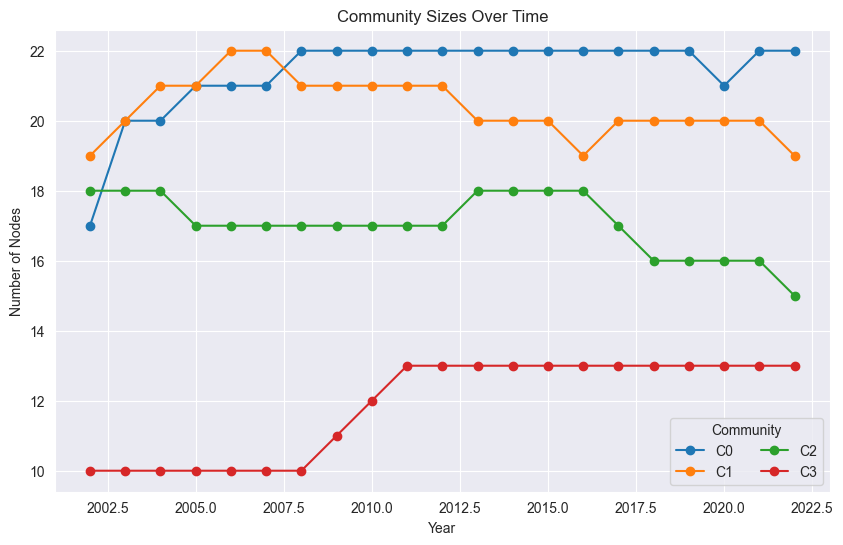

In [26]:
plot_community_sizes_over_time(temporal_membership, years_of_interest)

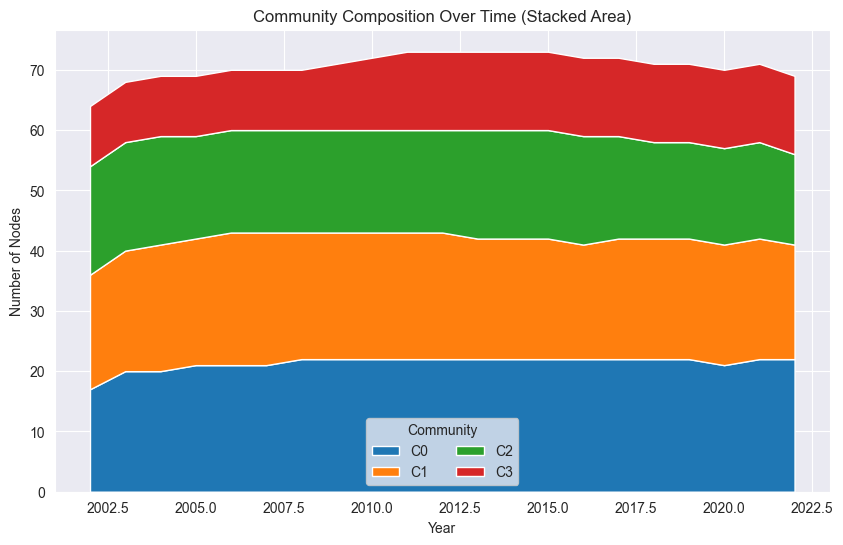

In [27]:
plot_community_stacked_area(temporal_membership, years_of_interest)


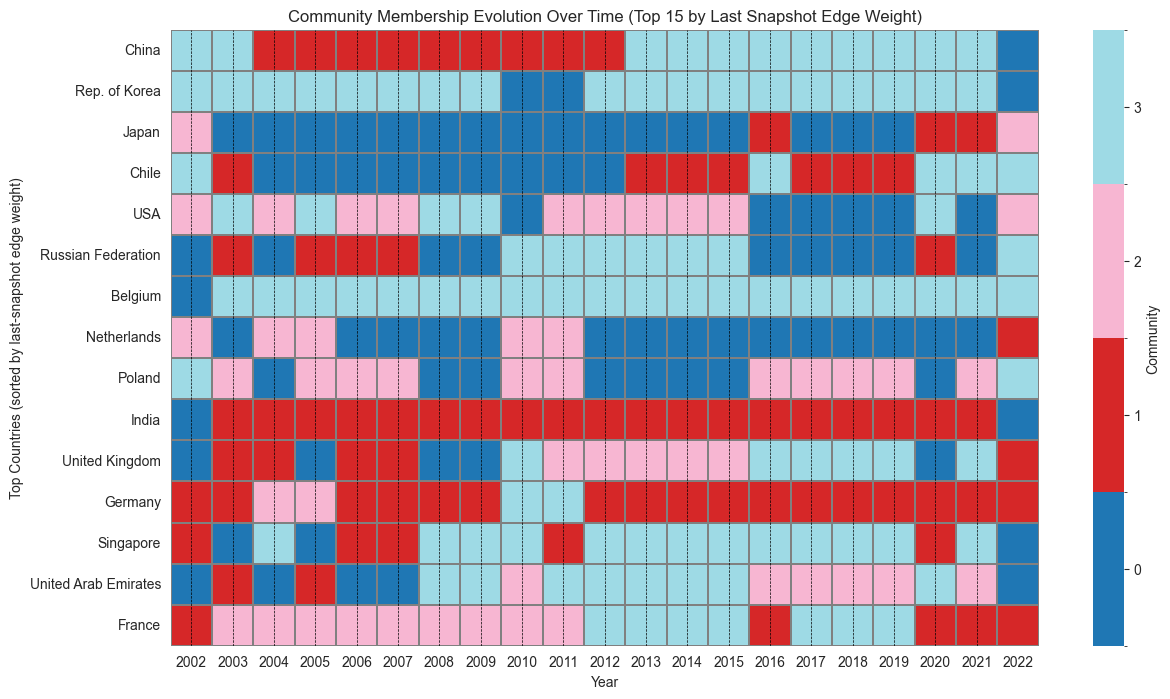

In [28]:
plot_top_countries_heatmap(temporal_membership, snapshots, years_of_interest, top_n=15)

### Block Model

In [ ]:
from dataloader import DataLoader

loader = DataLoader(hs_code=282520)
df = loader.get_data()

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
import igraph as ig
from itertools import product

################################################################################
# Device
################################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
################################################################################
# Node Features
################################################################################
node_features = [
    'avg_gdpcap_exp',
    'avg_gdpcap_imp',
    'wto_member',
    'eu_member',
    'avg_pop'
]

################################################################################
# Volume for adjacency building
################################################################################
edge_feature_cols = [
    "q"
]

In [ ]:
################################################################################
# Helper Functions
################################################################################
def filter_top_countries(df: pd.DataFrame, top_percent: float = 0.5):
    exp_sum = df.groupby('export_country')['v'].sum()
    imp_sum = df.groupby('import_country')['v'].sum()
    total_trade = exp_sum.add(imp_sum, fill_value=0).sort_values(ascending=False)
    cutoff_index = int(len(total_trade)*top_percent)
    cutoff_countries = total_trade.index[:cutoff_index]
    df_filtered = df[
        df['export_country'].isin(cutoff_countries) & 
        df['import_country'].isin(cutoff_countries)
    ].copy()
    return df_filtered

def compute_total_trade_volume(df: pd.DataFrame):
    grouped = df.groupby(['t', 'export_country', 'import_country'], as_index=False)['v'].sum()
    grouped.rename(columns={'v': 'total_trade_v'}, inplace=True)
    df = df.merge(grouped, on=['t','export_country','import_country'], how='left')
    df['total_trade_v'] = df['total_trade_v'].fillna(0.0)
    return df

def build_node_df(df, all_countries):
    node_df = pd.DataFrame(index=all_countries)
    node_df['avg_gdpcap_exp'] = df.groupby('export_country')['gdpcap_d'].mean()
    node_df['avg_gdpcap_imp'] = df.groupby('import_country')['gdpcap_o'].mean()

    wto_members = set(df[df['wto_o'] == 1]['export_country']) | set(df[df['wto_d'] == 1]['import_country'])
    eu_members = set(df[df['eu_o'] == 1]['export_country']) | set(df[df['eu_d'] == 1]['import_country'])

    node_df['wto_member'] = node_df.index.map(lambda c: 1.0 if c in wto_members else 0.0)
    node_df['eu_member'] = node_df.index.map(lambda c: 1.0 if c in eu_members else 0.0)
    node_df['avg_pop'] = df.groupby('export_country')['pop_o'].mean()

    node_df = node_df.fillna(0.0)
    for c in all_countries:
        if c not in node_df.index:
            node_df.loc[c] = [0,0,0,0,0]
    return node_df

In [111]:
################################################################################
# Blockmodel
################################################################################
def concor_pass(matrix: np.ndarray):
    matrix_centered = matrix - matrix.mean(axis=1, keepdims=True)
    avg_row = matrix_centered.mean(axis=0)
    corr_vals = []
    for row in matrix_centered:
        denom = np.linalg.norm(row)*np.linalg.norm(avg_row)
        if denom < 1e-12:
            corr_vals.append(0.0)
        else:
            corr_vals.append(np.dot(row, avg_row)/denom)
    corr_vals = np.array(corr_vals)
    signs = np.where(corr_vals >= 0, 1, -1)
    return signs

def multi_pass_concor_iter(matrix: np.ndarray, max_passes=5, tol=1e-3):
    prev_signs = None
    for _ in range(max_passes):
        cur_signs = concor_pass(matrix)
        if prev_signs is not None:
            diff = np.mean(cur_signs != prev_signs)
            if diff < tol:
                break
        prev_signs = cur_signs
    return cur_signs

def recursive_concor(matrix: np.ndarray, depth: int = 2, max_passes=5):
    N = matrix.shape[0]
    labels = np.zeros(N, dtype=int)

    def split_indices(idxs, current_label, level):
        if level == depth or len(idxs) <= 1:
            for idx in idxs:
                labels[idx] = current_label
            return

        submat = matrix[idxs, :]
        signs = multi_pass_concor_iter(submat, max_passes=max_passes)
        group1 = idxs[signs >= 0]
        group2 = idxs[signs < 0]

        if len(group1) == 0 or len(group2) == 0:
            for idx in idxs:
                labels[idx] = current_label
            return

        for idx in group1:
            labels[idx] = current_label
        next_label = labels.max() + 1
        for idx in group2:
            labels[idx] = next_label

        split_indices(group1, current_label, level+1)
        split_indices(group2, next_label, level+1)

    all_i = np.arange(N)
    split_indices(all_i, 0, 0)
    return labels

def blockmodel_communities(ig_graph: ig.Graph, depth: int = 2):
    A = np.array(ig_graph.get_adjacency(attribute="weight").data, dtype=float)
    A = np.nan_to_num(A, nan=0.0)
    membership = recursive_concor(A, depth=depth, max_passes=5)
    return membership

################################################################################
# Plot Heatmap of Top Countries
################################################################################
def plot_top_countries_heatmap(temporal_membership, snapshots, years_of_interest, top_n=30):
    node_to_country = {}
    for snapshot in snapshots:
        for v in snapshot.vs:
            node_to_country[v.index] = v["_nx_name"]

    v_attr = "weight"
    last_snapshot = snapshots[-1]
    node_weights = {}
    if last_snapshot.ecount() > 0:
        for e in last_snapshot.es:
            w = e[v_attr] if v_attr in last_snapshot.edge_attributes() else 0.0
            s = e.source
            t = e.target
            node_weights[s] = node_weights.get(s, 0.0) + w
            node_weights[t] = node_weights.get(t, 0.0) + w

    most_relevant_nodes = sorted(node_weights, key=node_weights.get, reverse=True)[:top_n]
    most_relevant_countries = [node_to_country[n] for n in most_relevant_nodes]
    idx_map = {node: i for i, node in enumerate(most_relevant_nodes)}

    num_slices = len(temporal_membership)
    mat = np.full((len(most_relevant_nodes), num_slices), -1)
    for t, mem in enumerate(temporal_membership):
        for node_id, comm in enumerate(mem):
            if node_id in idx_map:
                row = idx_map[node_id]
                mat[row, t] = comm

    unique_comms = np.unique(mat[mat >= 0])
    unique_comms = np.sort(unique_comms)

    from matplotlib.colors import BoundaryNorm
    base_cmap = plt.cm.get_cmap("tab20", len(unique_comms))
    boundaries = np.arange(len(unique_comms) + 1) - 0.5
    norm = BoundaryNorm(boundaries, base_cmap.N)

    plt.figure(figsize=(20,14))
    masked_data = np.ma.masked_where(mat < 0, mat)

    ax = sns.heatmap(
        masked_data,
        cmap=base_cmap,
        norm=norm,
        cbar_kws={"label": "Blockmodel Community"},
        xticklabels=years_of_interest,
        yticklabels=most_relevant_countries,
        linewidths=0.1,
        linecolor="gray"
    )
    plt.xlabel("Year")
    plt.ylabel("Top Countries (by weight in last snapshot)")
    plt.title("Blockmodel Communities Over Time")

    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.arange(len(unique_comms)))
    cbar.set_ticklabels(unique_comms)

    for t in range(num_slices - 1):
        plt.axvline(t+0.5, color="black", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

################################################################################
# Build Snapshots & Detect Communities (Only "q" used for adjacency!)
################################################################################
def run_blockmodel_community_detection(
    df: pd.DataFrame,
    start_year: int,
    end_year: int,
    top_percent: float,
    edge_volume_threshold: float,
    log_transform: bool,
    window_size: int = 1,
    depth: int = 2
):
    df = filter_top_countries(df, top_percent=top_percent)

    df = compute_total_trade_volume(df)

    years = sorted(df['t'].unique())
    years_of_interest = [y for y in years if start_year <= y <= end_year]
    if len(years_of_interest) < 1:
        raise ValueError("No valid years after filtering.")

    all_countries = np.union1d(df['export_country'].unique(), df['import_country'].unique())

    snapshots = []
    temporal_membership = []

    for y in years_of_interest:
        start_yr = max(df['t'].min(), y - window_size + 1)
        df_window = df[(df['t'] >= start_yr) & (df['t'] <= y)].copy()

        df_window['yearly_total_v'] = df_window.groupby('t')['v'].transform('sum')
        df_window['v'] = df_window['v'] / (df_window['yearly_total_v'] + 1e-9)
        if log_transform:
            df_window['v'] = np.log1p(df_window['v'])

        _ = build_node_df(df_window, all_countries)

        df_window["q"] = pd.to_numeric(df_window["q"], errors='coerce').fillna(0.0)

        scaler = MinMaxScaler()
        q_vals = df_window[["q"]].values
        q_vals_scaled = scaler.fit_transform(q_vals)

        mask = q_vals_scaled[:, 0] > edge_volume_threshold
        df_window = df_window[mask]
        q_vals_scaled = q_vals_scaled[mask]

        ig_graph = ig.Graph()
        ig_graph.add_vertices(len(all_countries))
        ig_graph.vs["name"] = [str(c) for c in all_countries]
        ig_graph.vs["_nx_name"] = list(all_countries)

        if len(df_window) > 0:
            edges_dict = {}
            country_to_id = {c: i for i, c in enumerate(all_countries)}
            for (scaled_val, row) in zip(q_vals_scaled, df_window.itertuples()):
                s = country_to_id[row.export_country]
                t = country_to_id[row.import_country]
                edges_dict[(s, t)] = edges_dict.get((s, t), 0.0) + scaled_val[0]

            edge_list = list(edges_dict.keys())
            weights = list(edges_dict.values())
            ig_graph.add_edges(edge_list)
            ig_graph.es["weight"] = weights

        snapshots.append(ig_graph)

    for ig_graph in snapshots:
        if ig_graph.ecount() == 0:
            membership = [0]*ig_graph.vcount()
        else:
            membership = blockmodel_communities(ig_graph, depth=depth)
        temporal_membership.append(membership)

    return {
        'all_countries': all_countries,
        'years_of_interest': years_of_interest,
        'temporal_membership': temporal_membership,
        'snapshots': snapshots
    }

_initialize_data took 41.9338 seconds
Using device: cpu


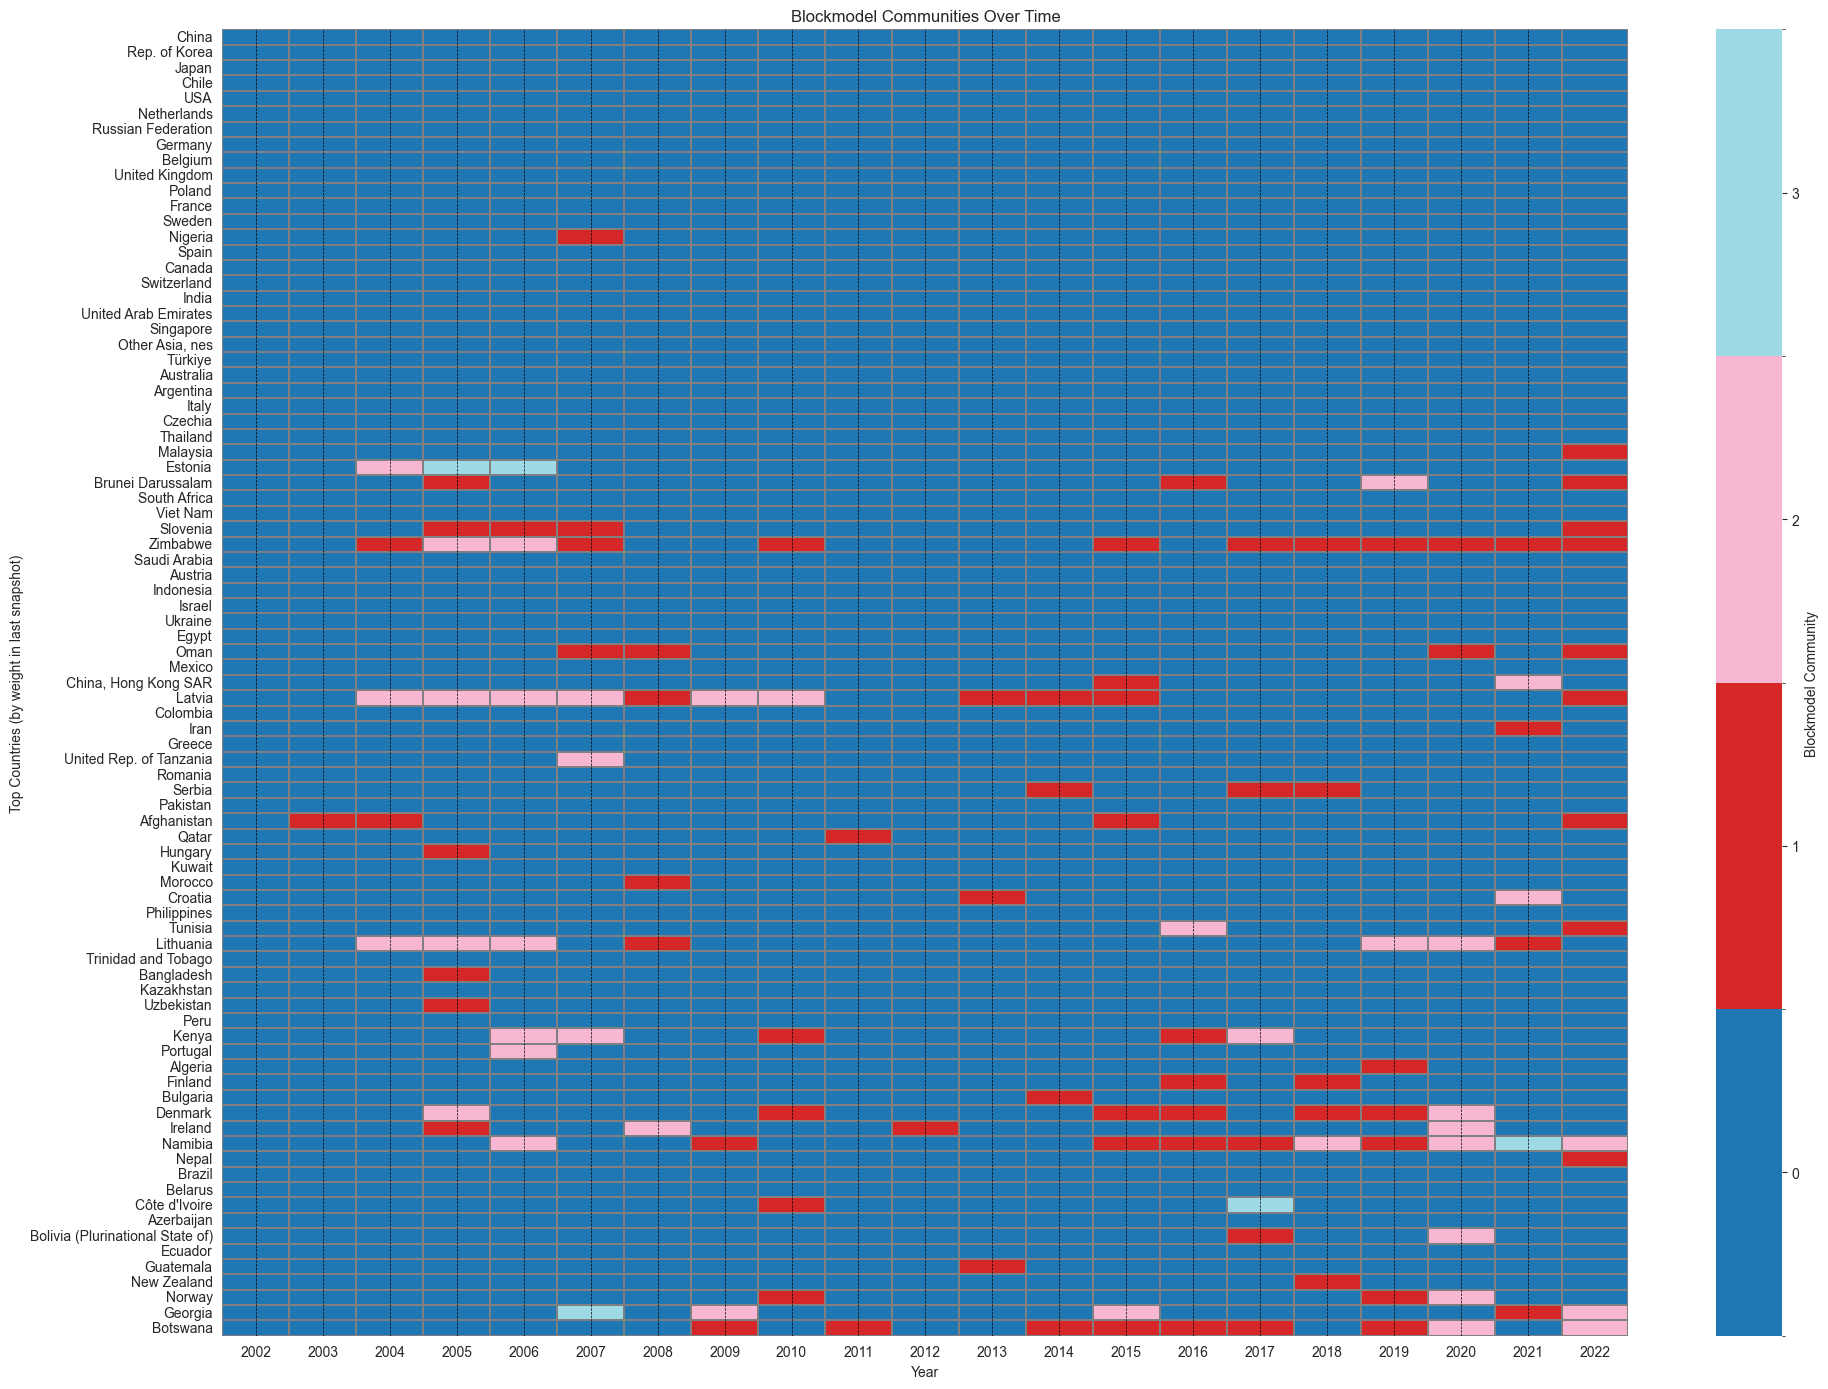

In [138]:
################################################################################
# Parameters
################################################################################
start_year = 2002
end_year = 2022
top_percent = 0.5
edge_volume_threshold = 0
log_transform = True
window_size = 1
depth = 4

results = run_blockmodel_community_detection(
    df=df.to_pandas(),
    start_year=start_year,
    end_year=end_year,
    top_percent=top_percent,
    edge_volume_threshold=edge_volume_threshold,
    log_transform=log_transform,
    window_size=window_size,
    depth=depth
)

temporal_membership = results["temporal_membership"]
snapshots = results["snapshots"]
years_of_interest = results["years_of_interest"]
all_countries = results["all_countries"]

plot_top_countries_heatmap(temporal_membership, snapshots, years_of_interest, top_n=100)